# Basic routine for dense_basis + grizli spectrophotometric fitting.



### What is `CARBS`?

`CARBS` stands for CANUCS Adaptive Resolved Bayesian SED-Fitting, and is a package for performing full spectrophotometric modeling and fitting using the grizli and Dense Basis codes. The Dense Basis code can be found [here](https://dense-basis.readthedocs.io/en/latest/), 
and grizli can be found [here](https://grizli.readthedocs.io/en/master/). 

This is the core of a package to extract the physical properties of galaxies (stellar masses, star formation rates and histories, dust content, chemical enrichment and redshift) utilizing all possible spectral information available. The current code is capable of simultaneously fitting 3D-HST grism + photometry to extract physical parameters including star formation histories with uncertainties. 

### Upcoming :

Documentation will be available at [carbs.readthedocs.io](https://carbs.readthedocs.io), and this will be updated from the base wrappers it currently is to be a standalone package.

If you are interested in using or contributing to the project, please email me at kartheik.iyer@dunlap.utoronto.ca

### What do you need to get started?

- Clone this repo using `git clone https://github.com/NIRISS/CARBS.git` and navigate into the base folder with `cd CARBS`. Also get the base packages (dense_basis and grizli) and their requirements. 


- The dense_basis package provides the functionality to create smooth, non-parametric Gaussian process based star formation histories, and run them through FSPS to get corresponding spectral energy distributions. Grizli provides an interface to forward model 2d grism images and compute goodness-of-fit statistics to extract information about the physical parameters of observed galaxies. 


- Both grizli and python-fsps (which is a dependency for dense_basis) also have some environmental variables that need to be set in the .bashrc or .cshrc files. 


- The `db_grizli_photspec.py` file contains most of the functions needed to get us up and running, building on top of both the dense_basis and grizli packages. This is what we are going to import and use in this notebook. Since it is not a full package currently, please make sure that you are working in the directory that contains this file. . 

In [1]:
import CARBS as carbs
import numpy as np

Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.
Initialized stellar population with FSPS.


## Getting the data:

To access the database, create a text file containing the username, password, and database name on separate lines, and read it in using `carbs.import_AWS_credentials()`. 

In [2]:
db_name, db_word, db_base = carbs.import_AWS_credentials('../../CARBS/credentials.txt')
engine = carbs.load_grizli_database(db_name, db_word, db_base)

We currently use the 3D-HST GOODS-South catalog (Skelton+14, Brammer+12) to find galaxies with matched spectrophotometry. If you don't have these files, or would like to use a different field, please download them from [the 3D-HST data release page](https://3dhst.research.yale.edu/Data.php).

In [3]:
cat = carbs.import_phot_cat(phot_cat_path = '../../CARBS/catalogs/goodss_3dhst.v4.1.cat', 
                            z_cat_path = '../../CARBS/catalogs/goodss_3dhst.v4.1.zout')

obs_id, obs_sed, obs_err, sed_cat, redshift_cat = cat

Picking a redshift range, we now find galaxies that have grism matches in the database. 

In [4]:
good_ids = carbs.find_matched_obs(z_low = 0.2, z_high = 0.5, 
                            redshift_cat = redshift_cat, sed_cat = sed_cat,
                            engine = engine)

# galaxies: 47
match for i = 2, with N: 2
gal_id: 6226, z_spec: 0.367
match for i = 4, with N: 1
gal_id: 7494, z_spec: 0.293
match for i = 7, with N: 1
gal_id: 9212, z_spec: 0.414
match for i = 13, with N: 1
gal_id: 11742, z_spec: 0.422
match for i = 14, with N: 1
gal_id: 13531, z_spec: 0.415
match for i = 16, with N: 1
gal_id: 13841, z_spec: 0.366
match for i = 19, with N: 1
gal_id: 15280, z_spec: 0.445
match for i = 21, with N: 1
gal_id: 15822, z_spec: 0.457
match for i = 25, with N: 1
gal_id: 17138, z_spec: 0.458
match for i = 31, with N: 1
gal_id: 19459, z_spec: 0.338
match for i = 33, with N: 2
gal_id: 19745, z_spec: 0.233
match for i = 42, with N: 1
gal_id: 26377, z_spec: 0.438
match for i = 44, with N: 1
gal_id: 26696, z_spec: 0.227


we pick a galaxy for the current analysis, and load its grism observations into grizli's `multibeam` object.

In [5]:
mb, z_grism, gal_id = carbs.get_matched_multibeam(matched_id = 21, 
                                          good_ids = good_ids, 
                                          sed_cat = sed_cat, redshift_cat = redshift_cat, engine = engine)

filter_list = 'filter_list_3dhst.dat'
filt_dir = '../../CARBS/filters'

galsed, galerr = carbs.get_matched_phot(mb, obs_sed, obs_err, gal_id, z_grism, 
                                  filter_list = filter_list, filt_dir = filt_dir)

gal_id: 15822, z_spec: 0.457
N:  1
gds-grism-j033236m2748 24915
Grism redshift: 0.4606
load_master_fits: gds-grism-j033236m2748_24915.beams.fits
1 ibhj04foq_flt.fits G141
2 ibhj04fvq_flt.fits G141
3 ibhj04gdq_flt.fits G141
4 ibhj04glq_flt.fits G141


Let's quickly visualize how the observations look before moving to the fitting part.

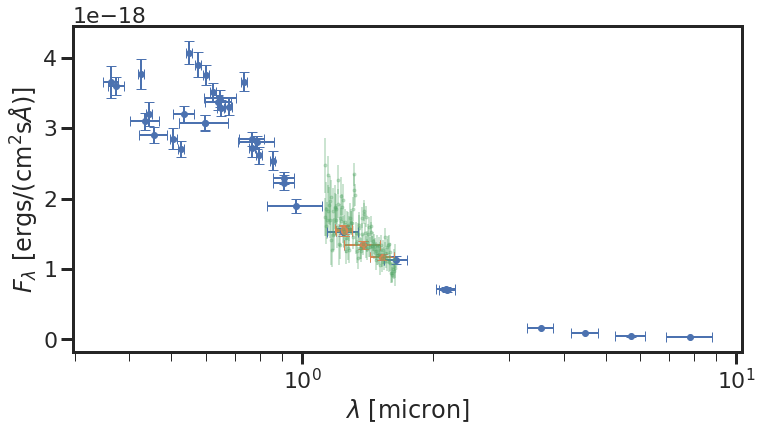

In [6]:
carbs.plot_matched_spectrophotometry(mb, z_grism, gal_id, obs_sed, obs_err, 
                               filter_list = filter_list, 
                               filt_dir = filt_dir)

## Some setup before fitting:

- `pg_params` samples from the priors to provide starting points for the ensemble of MCMC walkers. Run the first time, this takes a few minutes since FSPS needs to load templates for each metallicity from disk the first time it is queried. You might see faster performance using an SSD, but even otherwise should start seeing a dramatic improvement once the progress bar crosses ~30.
- `fcs, fc_zgrid` spline the filter transmission curves to the FSPS wavelength range, for faster computation during the subsequent fit.

In [7]:
pg_params = carbs.get_pg_theta(z_grism, filter_list = filter_list, filt_dir = filt_dir)

temp_theta = np.array([10.7,-1.0,0.25,0.5,0.75,0.0,0.0,z_grism])
stelmass = []; galmass = []

spec, wave, stelmass, galmass = carbs.spec_from_FSPS(temp_theta, stelmass, galmass)

fcs, fc_zgrid = carbs.make_fcs(wave, z_grism-1e-3, z_grism+1e-3,
                              filter_list = filter_list, filt_dir = filt_dir)

100%|██████████| 100/100 [03:26<00:00,  2.07s/it]


Path exists. Saved atlas at : pregrids/test_atlas_100_Nparam_3.mat


100%|██████████| 4/4 [00:00<00:00,  5.22it/s]


# All right, now we're ready to do the joint grism+photometry fitting!

Let's let the emcee ensemble walker run for a while, and see how the posteriors look. For now, we choose 100 walkers, each of which takes 500 steps through the parameter space. To ensure that we don't start off in weird portions of parameter space, we also let the ensemble 'burn in' for a few steps. This can be further scrutinized by checking to see if any of the walkers gets stuck in a small part of parameter space after the run and adjusting accordingly. 

- `fit_type` controls whether the likelihood calculation step uses only the `grism` data (which tend to be poorer constraints on mass-sfr), or only the photometric SED (`phot`; which can poorly constrain the dust-metallicity posterior), or jointly fits both (`grismphot`). 

- `chi2wt` controls the relative weights of the spectroscopy and the photometry, and can be adjusted for a sample to optimally account for over- and under-estimated uncertainties on these quantities.

In [8]:
# the argument chi2wt weights the goodness-of-fit of the photometry relative to the grism. 
# acceptable inputs are any number between 0 and 1, with 
# only phot = 0.0
# only grism = 1.0

n_steps = 1000
n_burnin = 10
n_walkers = 100

samples, stelmass, galmass = carbs.db_mcmc(mb, galsed, galerr + 0.1*galsed, 
                                           fcs, fc_zgrid, z_grism, pg_params, 
                                           fit_type = 'grismphot', chi2wt = 0.0001,
                                           n_steps = n_steps, n_burnin = n_burnin, n_walkers = n_walkers,
                                           filter_list = filter_list, filt_dir = filt_dir)



burn-in time: 13.0 sec
[####################################################################################################]
time taken to run: 53.5 min.
chi2/DoF from grism: 0.99 and phot: 0.92.
overall offset between median spec and grism: 0.828


# Plotting all the posteriors and fits:

We now run `carbs.plot_all_fits()`, which makes four plots: 

1. showing the fit to the photometry,
2. using grizli's `mb.oned_figure()` to show the fit to the full grism data,
3. using `plot_emcee_posterior()` to create a plot of the posterior distributions for each parameter, and
4. using dense_basis in `plot_sfh_posteriors()` to show the posterior distribution for the star formation history.

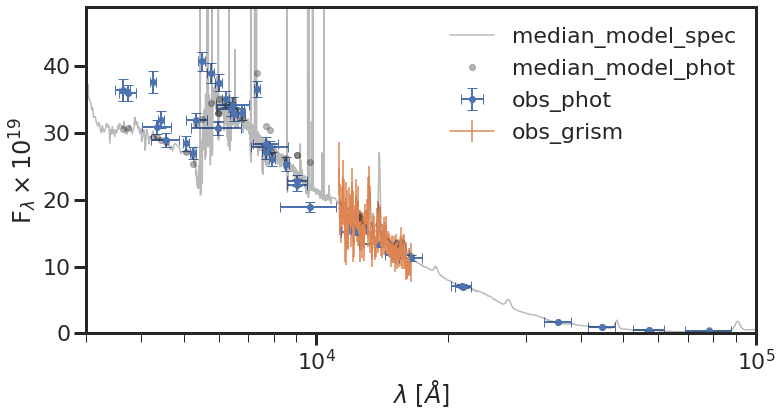

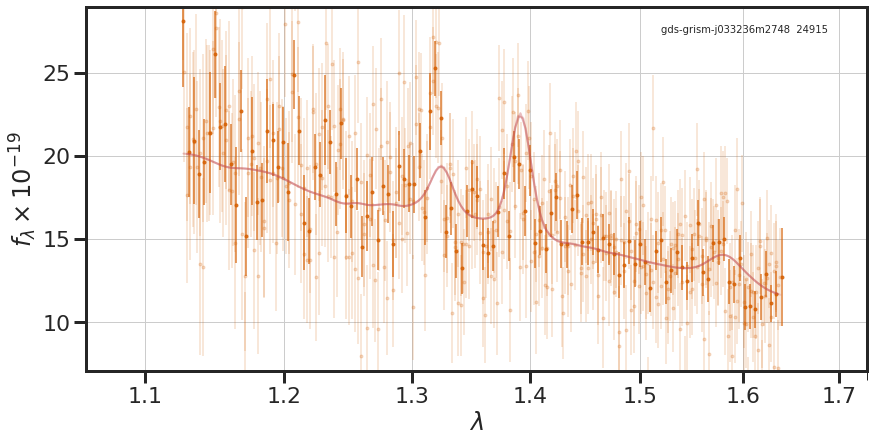

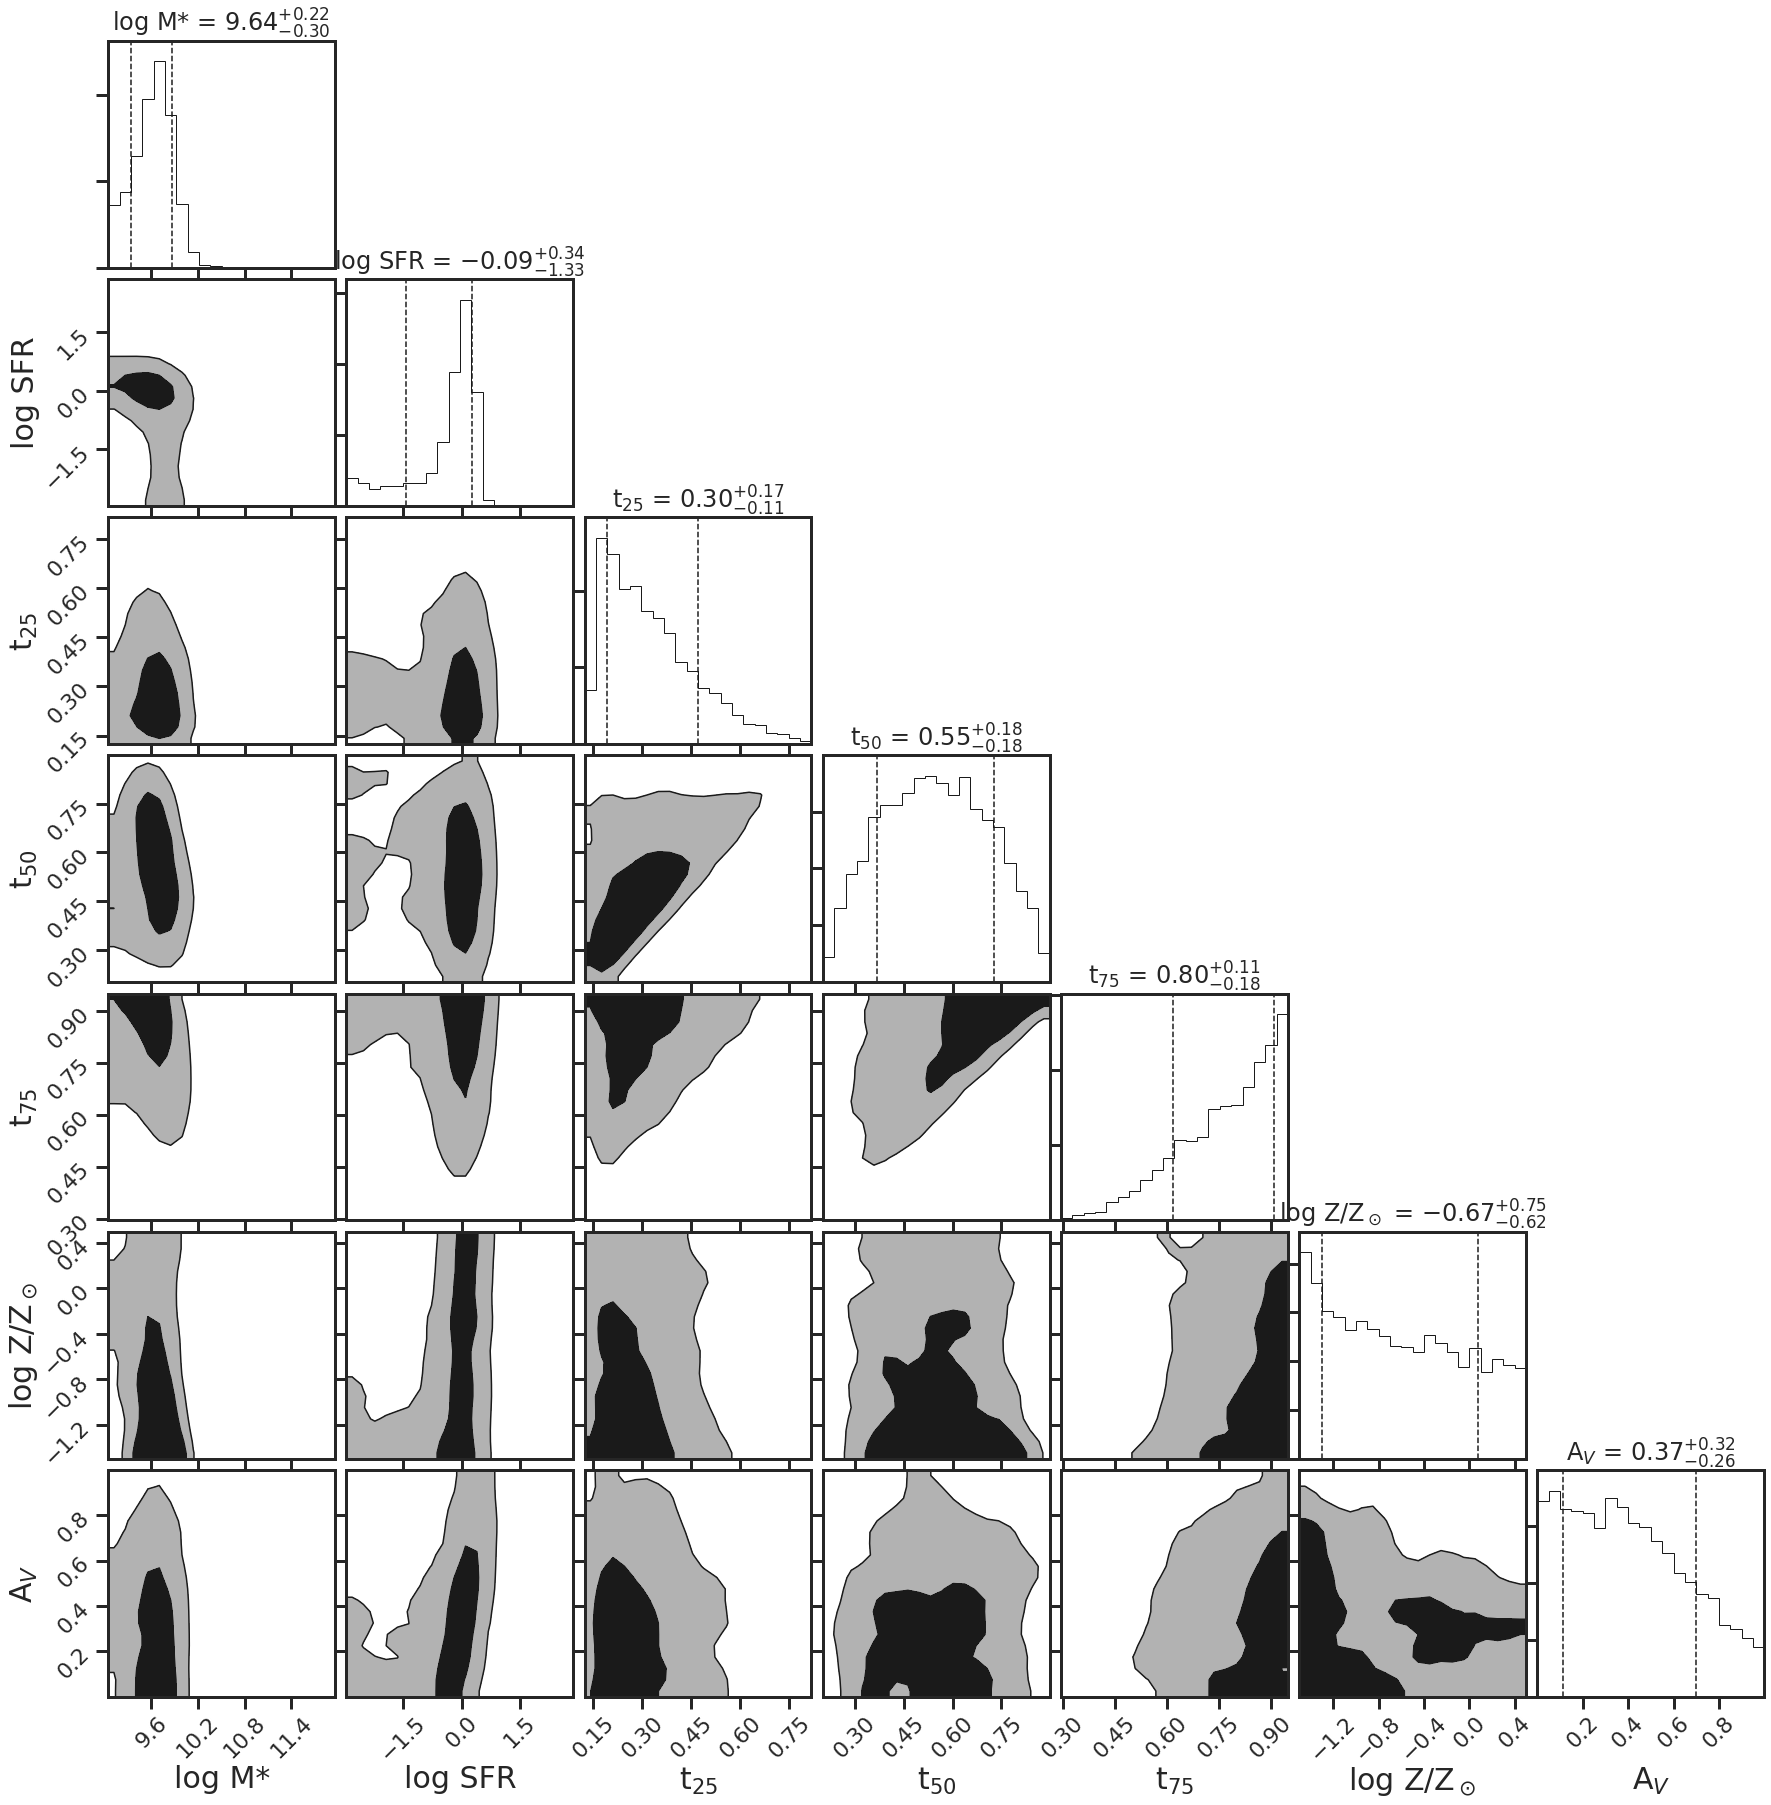

100%|██████████| 1000/1000 [00:01<00:00, 536.68it/s]


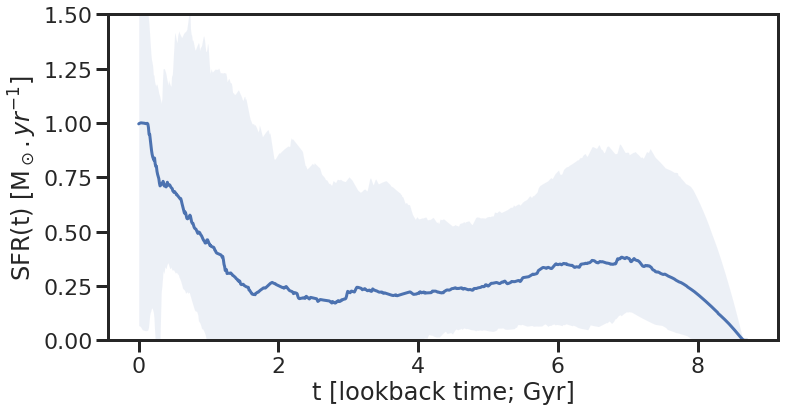

In [9]:
carbs.plot_all_fits(samples, stelmass, galmass, 
                    mb, z_grism, fcs, fc_zgrid, galsed, galerr + 0.03*galsed, 
                    filter_list = filter_list, filt_dir = filt_dir, num_sfh=1000, scaleto='phot')

In [16]:
samples.shape

(100000, 8)